# Introduction

In [ ]:
!pip install signatory --no-cache-dir --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for signatory: filename=signatory-1.2.6.1.9.0-cp312-cp312-linux_x86_64.whl size=12375752 sha256=b7cf26f1606dab95a6ed7aee3c5fe690979b466517a517462d70cb043b872f40
  Stored in directory: /tmp/pip-ephem-wheel-cache-obywd45h/wheels/ea/18/f4/25aee915ecc6b29d1a54962265ca510a889b7ea71905f446b5
Successfully built signatory


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import signatory

# Implementing Psi and other essential functions

We consider $\ell$ to be a list of tensors of increasing sizes $(1,d,d^2,\cdots,d^n)$ where $n$ is the depth parameter. i and j are arrays of length $m$.

In [ ]:
#we define a simple version of psi in which i and j are integers in {0,...,d-1}

def Psi(i,j,l,d):
    N=len(l)
    sol=[]
    sol.append(torch.zeros(1))
    for n in range(1,N):
        Z=torch.zeros(*[d]*n)
        for k in range(n):
            indices=[slice(None)]*n
            indices[k]=i
            hyperrow=l[n][indices]

            indices[k]=j
            Z[indices]+=hyperrow
        sol.append(Z)
    return sol

In [ ]:
#Generates a brownian motion

def generate_brownian(batch_size, points, d, T, seed=0):
    torch.manual_seed(seed)
    Z = T*torch.randn((batch_size, points-1, d))
    interval=[0.0, T]
    dt = (interval[1] - interval[0]) / (points - 1)
    W=torch.zeros((batch_size, points, d))
    W[:,1:,:]=np.sqrt(dt)*Z
    W=W.cumsum(dim=1)
    return W

In [ ]:
#Generates an augmented brownian motion

def generate_aug_brownian(batch_size, points, d, T, seed=0):
    torch.manual_seed(seed)
    Z = T*torch.randn((batch_size, points-1, d-1))
    interval=[0.0, T]
    dt = (interval[1] - interval[0]) / (points - 1)

    W=torch.zeros((batch_size, points, d))
    W[:,1:,1:]=np.sqrt(dt)*Z
    W[:,1:,0]=dt
    W=W.cumsum(dim=1)
    return W

In [ ]:
#Generates the signature of a path
def getsig(path, depth):
    #path shape=(batch_size,path_length,d)
    batch_size,_,d=path.shape

    signatures = signatory.signature(path, depth)
    # Shape: (batch_size, d + d^2 + ... + d^n)
    # Concatenate the level-0 term (1) to the signatures
    level0 = torch.ones(batch_size, 1, device=path.device)
    signatures_full = torch.cat([level0, signatures], dim=1)
    # Shape: [batch_size, 1 + d + d² + ... + dⁿ]
    #unflatten signature
    sizes = [d**k for k in range(depth + 1)]  # [1, d, d², ..., dⁿ]
    lis=list(torch.split(signatures_full, sizes, dim=1))
    return [lis[0].reshape((batch_size),1)]+[s.reshape((batch_size,*[d]*k)) for s,k in zip(lis[1:],np.arange(1,depth+1))]

In [ ]:
#product between two elements of the tensorspace
def scalar_product(l_parts, sig_parts):
    return sum(
        torch.sum(l.flatten() * sig.flatten(start_dim=1), dim=1)
        for l, sig in zip(l_parts, sig_parts)
    )
# Shape: (batch_size,)

In [ ]:
def plot_path(path,T,batch_list=[0]):
    _,points,d=path.shape
    t_axis = np.linspace(0, T, points)
    for batch in batch_list:
        for i in range(d):
            plt.plot(t_axis,path[batch,np.arange(points),i])
    plt.show()


In [ ]:
#function that gives index of a time t in the np.linspace(0,T,points)
def time(t,T,points):
    return int(t*(points-1)/T)

In [ ]:
def inf_norm(x):
  return max(abs(x))

For norms: torch.linalg.norm(A,ord=ord) with ord= 1 or 2

In [ ]:
def p(x,X_t,h_values,return_y=False,y='-inf'):
    # x can be a scalar or array
    bs=X_t.shape[0]
    x = torch.asarray(x).reshape(-1,1)
    if y=='-inf':
      mask = X_t >= x
      if return_y:
        return mask * h_values
      return torch.sum(mask * h_values, axis=1) / bs
    else:
      mask1=(X_t >= x.reshape(-1, 1)).long()
      mask2=(x>=y).long()
      ones=torch.ones(x.shape)
      Y=h_values*(mask1*mask2-(ones-mask1)*(ones-mask2))
      if return_y:
        return Y
      return torch.sum(Y,axis=1)/bs

In [ ]:
def upgraded_p(x,X_t,h_values):
    bs=X_t.shape[0]
    x = torch.asarray(x).reshape(-1,1)
    mask = (X_t >= x)
    EH2=torch.sum(h_values**2)/bs
    Var=torch.sum(mask * (h_values**2), axis=1) / bs
    mask2= (Var>=EH2/2)
    p=torch.sum(mask * h_values, axis=1) / bs
    EH=torch.mean(h_values)
    p_final=p-EH*mask2
    Var_final=mask2*(EH2-Var)+ ~mask2*Var - p_final**2
    return p_final,Var_final

In [ ]:
def upgraded_p_v2(x,X_t,h_values):
    bs=X_t.shape[0]
    x = torch.asarray(x).reshape(-1,1)
    mask = (X_t >= x)
    EH2=torch.sum(h_values**2)/bs
    Var=torch.sum(mask * h_values**2, axis=1) / bs
    mask2= (Var>=EH2/2)
    p=torch.sum(mask * h_values, axis=1) / bs
    EH=torch.mean(h_values)
    p_final=p-EH*mask2
    Var_final=Var-p_final**2
    return p_final,Var_final

In [ ]:
a=(torch.rand(1,10)>0.5)
print(a)
print(~a)

tensor([[ True, False, False, False, False, False,  True, False, False,  True]])
tensor([[False,  True,  True,  True,  True,  True, False,  True,  True, False]])


In [ ]:
def Riemann_Integral(path,t_axis):
  points=path.shape[0]
  delta=(t_axis[1:]-t_axis[:-1])
  path_left=path[:-1]
  return (path_left*delta).sum()

In [ ]:
#test
x=torch.linspace(-100,100,200)
f=1/(np.sqrt(2*torch.pi))*torch.exp(-1/2*x**2)
Riemann_Integral(f,x)


tensor(1.0000)

# Actual Polytnomials of a Brownian motion


In [ ]:
class Polynomials:
    def __init__(self, coefficients: torch.Tensor, exponents: torch.Tensor, W, t, T):
        """
        coefficients: shape (n_terms,)
        exponents: shape (n_terms, n_vars)
        """
        self.coefficients = coefficients.float()  # (N,)
        self.exponents = exponents.int()          # (N, D)
        self.N,self.d = exponents.shape
        self.W=W
        self.t=t
        self.T=T
        self.W_t=W[:,time(t,T,W.shape[1]),:]

    def get_X_t(self):
        """
        Evaluate polynomial at input x.
        x: (..., D) — batch of D-dimensional points
        Returns: (...,) — values of the polynomial at each point
        """
        x = self.W_t.unsqueeze(-2)  # (..., 1, D)
        powers = x ** self.exponents  # (..., N_terms, D)
        monomials = torch.prod(powers, dim=-1)  # (..., N_terms)
        result = monomials @ self.coefficients  # (...,)
        return result

    def phi(self, ell, j):
        ind=torch.where(ell[1][:,j]!=0)
        expo=torch.zeros_like(ell[1])
        expo[ind]=ell[1][ind]
        jays=expo[:,j]
        coef=ell[0]*jays
        expo[:,j][ind]-=1
        return coef,expo

    def compute_gradient_l(self):
        grad_coef=torch.zeros((self.d,self.N))
        grad_expo=torch.zeros((self.d,self.N,self.d))

        for j in range(self.d):
            grad_coef[j,:],grad_expo[j,:,:]=(self.phi((self.coefficients,self.exponents),j))
        self.gradient_l= grad_coef,grad_expo

    def compute_hess_l(self):
        hess_coef=torch.zeros((self.d,self.d,self.N))
        hess_expo=torch.zeros((self.d,self.d,self.N,self.d))
        for j in range(d):
            for i in range(d):
                a=self.phi((self.coefficients,self.exponents),i)
                hess_coef[i,j,:],hess_expo[i,j,:,:] = self.phi(a,j)
        self.hessian_l=hess_coef, hess_expo

    def compute_gradient(self):
        # i, N, D
        # bs, D
        self.compute_gradient_l()
        x=self.W_t.unsqueeze(-2)
        x=x.unsqueeze(-3) # (bs,1,1,D)
        powers= x**self.gradient_l[1] #(bs,D,N,D)
        monomials = torch.prod(powers, dim=-1)  # (bs,D,N)
        result=torch.sum(monomials * self.gradient_l[0],dim=-1) # (bs,D)
        self.gradient=result

    def compute_hessian(self):
        # i, N, D
        # bs, D
        self.compute_hess_l()
        x=self.W_t.unsqueeze(-2)
        x=x.unsqueeze(-3) # (bs,1,1,D)
        x=x.unsqueeze(-3) # (bs,1,1,1,D)
        powers= x**self.hessian_l[1] #(bs,D,D,N,D)
        monomials = torch.prod(powers, dim=-1)  # (bs,D,N)
        result=torch.sum(monomials * self.hessian_l[0],dim=-1) #(bs,D,D)
        self.hessian=result

    def scalar_prod(self, ell, x):
        # ell is a tuple of coefficients and exponents
        x = x.unsqueeze(-2)  # (..., 1, D)

        powers = x ** ell[1]  # (..., N_terms, D)
        monomials = torch.prod(powers, dim=-1)  # (..., N_terms)
        result = monomials @ ell[0]  # (...,)
        return result

    def H1(self,i=0):
        return self.W_t[:,i]/(self.t*self.gradient[:,i])+self.hessian[:,i,i]/(self.gradient[:,i]**2)

    def H3(self):
        sigma=(self.gradient**2).sum(dim=1)
        term1=(self.W_t/self.t*self.gradient-torch.diagonal(self.hessian,dim1=-2,dim2=-1)).sum(dim=1)
        term2=(self.gradient.unsqueeze(dim=-2)* self.hessian * self.gradient.unsqueeze(dim=-1)).sum(dim=(-1,-2))
        return 1/sigma*(term1+1/sigma*(2*term2))


    def print_grad(self):
        print(self.gradient)



In [ ]:
test=torch.ones((10,3,3))
t1=torch.ones((10,3))
t2=torch.ones((10,3))*2
(t2.unsqueeze(dim=-2)*test * t1.unsqueeze(dim=-1)).sum(dim=(1,2))


tensor([18., 18., 18., 18., 18., 18., 18., 18., 18., 18.])

In [ ]:
t=1
T=1
d=1
bs=10000
W=generate_brownian(bs,5000,d,T,1)

In [ ]:
a=torch.ones((6,1))
a[0,0]=0

a[2,0]=2
a[3,0]=3
a[4,0]=4
a[5,0]=5
b=torch.tensor([1,1,2,2,-2,1])
pol1=Polynomials(b,a,W,t,T)
pol1.compute_gradient()
pol1.compute_hessian()

a=torch.ones((4,1))
a[0,0]=0

a[2,0]=2
a[3,0]=3

b=torch.tensor([1,1,2,2])
pol2=Polynomials(b,a,W,t,T)
pol2.compute_gradient()
pol2.compute_hessian()

a=torch.ones((6,1))
a[0,0]=0

a[2,0]=2
a[3,0]=3
a[4,0]=10
a[5,0]=13
b=torch.tensor([1,1,2,2,-2,1])
pol3=Polynomials(b,a,W,t,T)
pol3.compute_gradient()
pol3.compute_hessian()

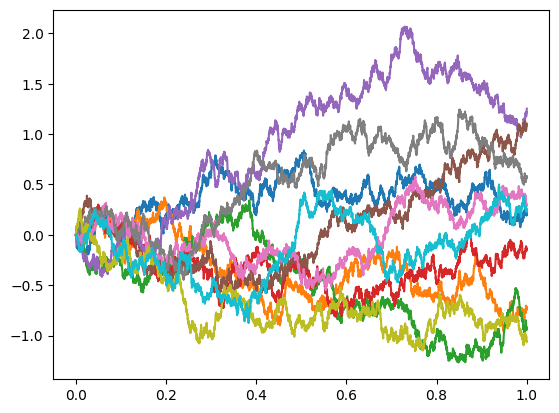

In [ ]:
plot_path(W,1,range(10))

tensor(0.8254)
tensor(0.8840)
tensor(0.7594)


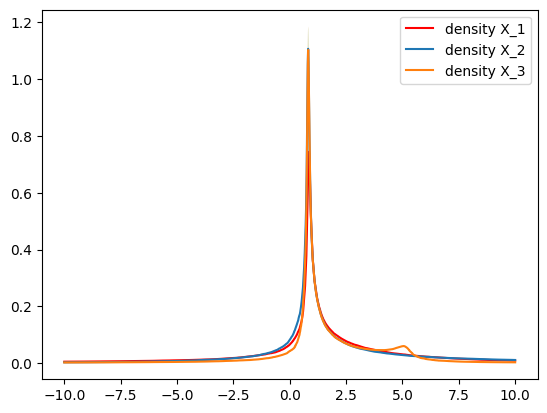

In [ ]:
x=torch.linspace(-10,10,5000)
u,v=upgraded_p(x,pol1.get_X_t(),pol1.H3())
plt.plot(x,u,color="red",label='density X_1')
plt.fill_between(x,u-1.96*v/np.sqrt(bs),u+1.96*v/np.sqrt(bs),alpha=0.2)
#plt.plot(x,p(x,pol.get_X_t(),pol.H1()))
print(Riemann_Integral(u,x))

u,v=upgraded_p(x,pol2.get_X_t(),pol2.H3())
plt.plot(x,u,label='density X_2')
plt.fill_between(x,u-1.96*v/np.sqrt(bs),u+1.96*v/np.sqrt(bs),alpha=0.2)
#plt.plot(x,p(x,pol.get_X_t(),pol.H1()))
print(Riemann_Integral(u,x))

u,v=upgraded_p(x,pol3.get_X_t(),pol3.H3())
plt.plot(x,u,label='density X_3')
plt.fill_between(x,u-1.96*v/np.sqrt(bs),u+1.96*v/np.sqrt(bs),alpha=0.2)
#plt.plot(x,p(x,pol.get_X_t(),pol.H1()))
print(Riemann_Integral(u,x))

plt.legend()
plt.show()

In [ ]:
colors=['red','green','blue']

In [ ]:
u=[0,0,0]
v=[0,0,0]
u[0],v[0]=upgraded_p(x,pol2.get_X_t(),pol2.H3())
u[1],v[1]=upgraded_p(x,pol1.get_X_t(),pol1.H3())
u[2],v[2]=upgraded_p(x,pol3.get_X_t(),pol3.H3())

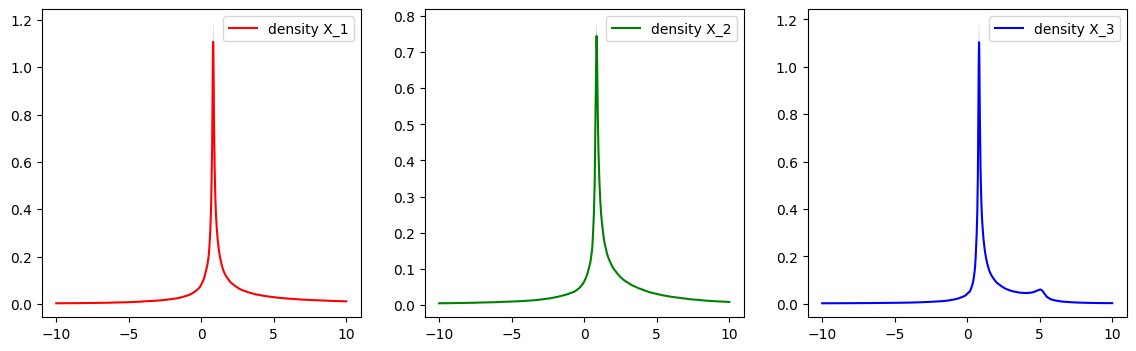

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
for i in range(3):

  ax[i].plot(x,u[i],color=colors[i],label=f'density X_{i+1}')
  ax[i].fill_between(x,u[i]-1.96*v[i]/np.sqrt(bs),u[i]+1.96*v[i]/np.sqrt(bs),alpha=0.5)

  ax[i].legend()
plt.show()

In [ ]:
for i in range(3):
  print(inf_norm(v[i]))
  print(torch.norm(v[i],p=2)/10000)

tensor(5.0167)
tensor(0.0025)
tensor(2.6114)
tensor(0.0014)
tensor(5.9656)
tensor(0.0028)


In [ ]:
a=torch.ones((1,1))*2
b=torch.tensor([1/2])
pol=Polynomials(b,a,W,t,T)
pol.compute_gradient()
pol.compute_hessian()

tensor(0.9989)


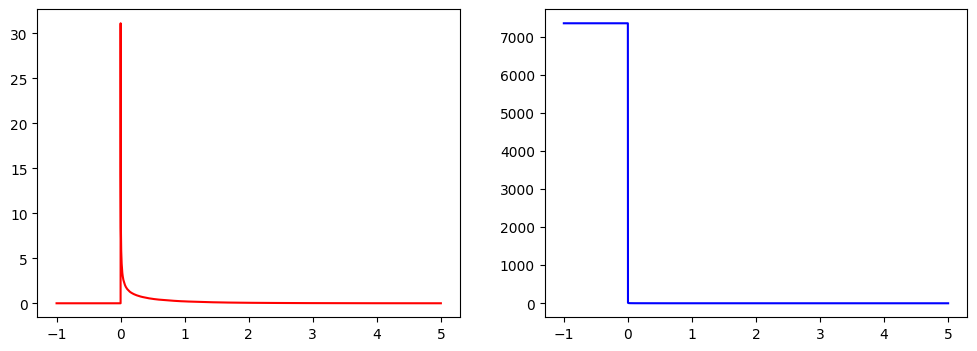

In [ ]:
### p vs upgraded_p
x=torch.linspace(-1,5,10000)
v=p(x,pol.get_X_t(),pol.H3())
u,_=upgraded_p(x,pol.get_X_t(),pol.H3())
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(x,u,color="red",label='density X_1')
ax[1].plot(x,v,color="blue",label='density X_1')
#plt.fill_between(x,u-1.96*v/np.sqrt(bs),u+1.96*v/np.sqrt(bs),alpha=0.2)
#plt.plot(x,p(x,pol.get_X_t(),pol.H1()))
print(Riemann_Integral(u,x))

tensor(0.9989)


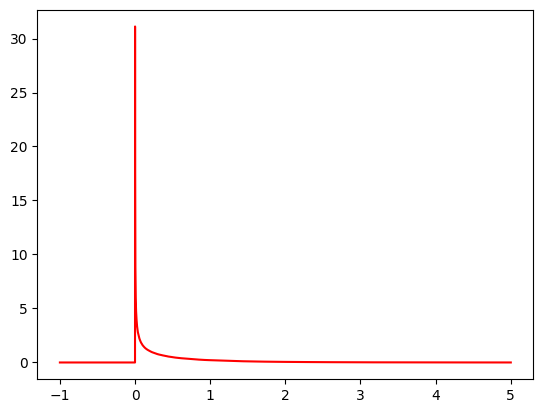

In [ ]:
gx=torch.linspace(-1,10,10000)
v=p(x,pol.get_X_t(),pol.H3())
plt.plot(x,u,color="red",label='density X_1')
#plt.fill_between(x,u-1.96*v/np.sqrt(bs),u+1.96*v/np.sqrt(bs),alpha=0.2)
#plt.plot(x,p(x,pol.get_X_t(),pol.H1()))
print(Riemann_Integral(u,x))

In [ ]:
#a=torch.tensor([[0,1,0,2],[0,0,1,2],[0,3,2,1]])
#b=torch.tensor([1,-4,6])
#pol=Polynomials(b,a,W,t,T)
#pol.compute_gradient()
#pol.compute_hessian()
#a.shape # N, D

# Simplified Signature

In [ ]:
#computation of weights:

def H(W,ell,j,t,T,i=0,X=None):
    if j==1:
        return W[:,time(t,T,points),i]/(t*ell[i])
    if j==2:
        return W[:,time(t,T,points),:].sum(axis=1)/(t*ell.sum())
    if j==3:
        return X[:,time(t,T,points)]/(t*np.linalg.norm(ell)**2)

In [ ]:
#estimating p_t
def pol_p(x,W,ell,j,t,T,i=0,X=None,return_y=False,y='-inf'):
    # x can be a scalar or array
    bs,points=X.shape
    x = torch.asarray(x).reshape(-1,1)
    h_values = H(W,ell,j,t,T,i=i,X=X)
    if y=='-inf':
      mask = X[:, time(t,T,points)] >= x

      if return_y:
        return mask * h_values
      return torch.sum(mask * h_values, axis=1) / bs
    else:
      mask1=(X[:, time(t,T,points)] >= x.reshape(-1, 1)).long()
      mask2=(x>=y).long()
      ones=torch.ones(x.shape)
      Y=h_values*(mask1*mask2-(ones-mask1)*(ones-mask2))
      if return_y:
        return Y
      return torch.sum(Y,axis=1)/bs

In [ ]:
# actuall value of pt(x):
def pol_P(t,x,ell):
    return 1/torch.sqrt(2*torch.pi*torch.linalg.vector_norm(ell)**2)*torch.exp(-x**2/(2*t*torch.linalg.vector_norm(ell)**2))

In [ ]:
paths = 10000
points = 2000
d=15
T=1.0
torch.manual_seed(43)
ell=torch.randn(d)

In [ ]:
W=generate_brownian(paths,points,d,T,43)

In [ ]:
# We define X
X=(W*ell).sum(axis=2)

In [ ]:
X.shape
#first coordinate is number of paths (for Montecarlo), second is discrete time

torch.Size([10000, 2000])

In [ ]:
estimated_density=[]
sp=torch.linspace(-20,20,5000)
real_density=pol_P(1,sp,ell)
for j in range(1,4):
  estimated_density.append(pol_p(sp,W,ell,j=j,t=1,T=T,i=0,X=X))


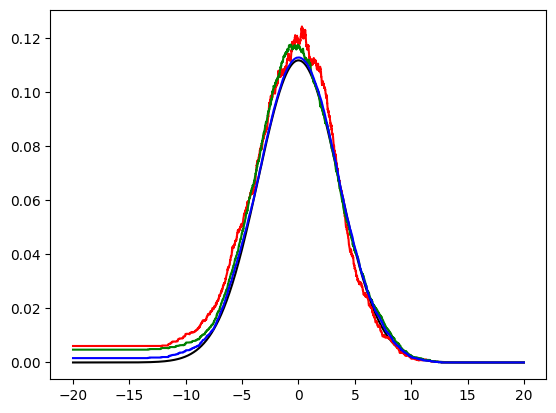

In [ ]:
plt.plot(sp,real_density,color='black')
colors=['red','green','blue']
for density,color in zip(estimated_density,colors):
  plt.plot(sp,density,color=color)
plt.show()

This image suggests that the third density formula has better convergence

### Confidence Intervals

Estimating the standard deviation of the different Formulas:

In [ ]:
Ys=[]
bs=W.shape[0]
#sp=torch.linspace(-20,20,5000)
for j in range(1,4):
  Ys.append(pol_p(sp,W,ell,j=j,t=1,T=T,i=0,X=X,return_y=True))

In [ ]:
stds=[]
for Y in Ys:
  stds.append(
      torch.sqrt(
          torch.sum(Y**2,axis=1)/bs-(torch.sum(Y,axis=1)/bs)**2)
      )

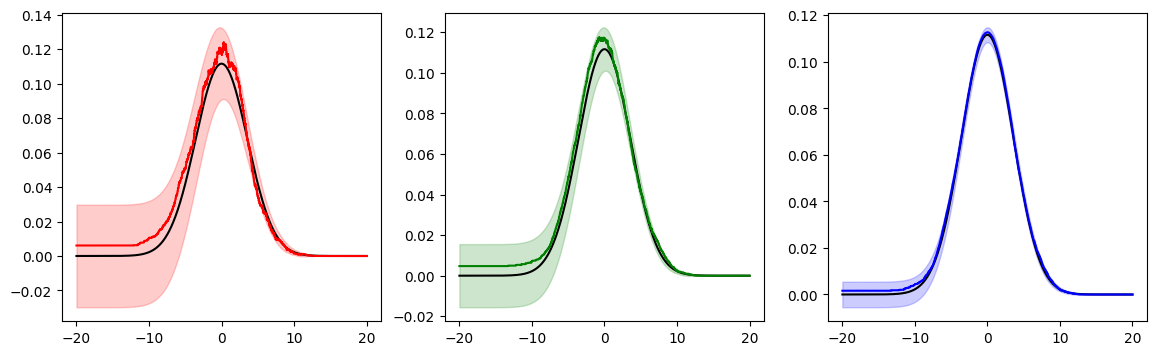

In [ ]:
q=1.96 # corresponds to 95% quantile of the standard-normal distribution
fig, ax = plt.subplots(1,3,figsize=(14,4))
for i in range(3):
  ax[i].plot(sp,real_density,color='black')
  ax[i].plot(sp,estimated_density[i],color=colors[i])
  ax[i].fill_between(sp,real_density-q*stds[i]/np.sqrt(bs),real_density+q*stds[i]/np.sqrt(bs),color=colors[i],alpha=.2)

In [ ]:
differences=[e-real_density for e in estimated_density]
j=1
for diff in differences:
  print('For the density ',j)
  print("average 2-norm error:", torch.linalg.norm(diff,ord=2)/sp.shape[0])
  print("average 1-norm error:", torch.linalg.norm(diff,ord=1)/sp.shape[0])
  print("maximal error:", inf_norm(diff),"\n")
  j+=1

For the density  1
average 2-norm error: tensor(8.2191e-05)
average 1-norm error: tensor(0.0046)
maximal error: tensor(0.0134) 

For the density  2
average 2-norm error: tensor(5.5117e-05)
average 1-norm error: tensor(0.0030)
maximal error: tensor(0.0099) 

For the density  3
average 2-norm error: tensor(1.6881e-05)
average 1-norm error: tensor(0.0010)
maximal error: tensor(0.0028) 



In [ ]:
for i in range(3):
  print(f"H{i+1}'s mean std: ",stds[i].mean())
  print(f"H{i+1}'s max std: ", stds[i].max(),"\n")

H1's mean std:  tensor(0.8528)
H1's max std:  tensor(1.5192) 

H2's mean std:  tensor(0.4501)
H2's max std:  tensor(0.7942) 

H3's mean std:  tensor(0.1609)
H3's max std:  tensor(0.2805) 



The third model clearly appears to be the best. In all three cases however, we can observe worst convergence for negative values of x. We will try to implement $p_t(x)=E[(\mathbf{1}_{y\leq x\leq X_t}-\mathbf{1}_{y> x> X_t})H(X_t;1)]$ instead. The fact that our density is centered suggest a good fit with the value $y=0$. We will however try a couple different values.

### Using Upgraded version

In [ ]:
# We use previously computed W, ell, X and t=1 to have a better comparaison with previous results
x=torch.linspace(-20,20,5000)
results=[]
t=1
bs,points=X.shape
for j in range(1,4):
  h_values=H(W,ell,j,t,T,X=X,)
  results.append(upgraded_p(x,X[:, time(t,T,points)],h_values))

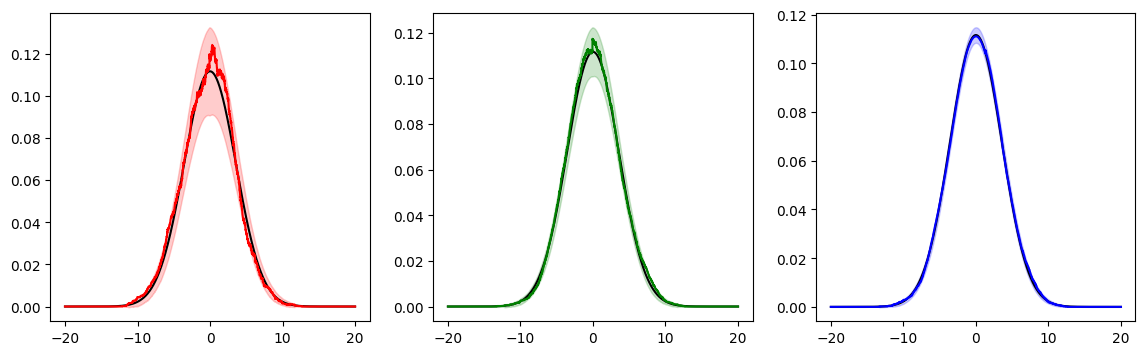

In [ ]:
q=1.96 # corresponds to 95% quantile of the standard-normal distribution
fig, ax = plt.subplots(1,3,figsize=(14,4))
for i in range(3):
  ax[i].plot(x,pol_P(1,x,ell),color='black')
  ax[i].plot(x,results[i][0],color=colors[i])
  ax[i].fill_between(x,pol_P(1,x,ell)-q*torch.sqrt(results[i][1])/np.sqrt(bs),pol_P(1,x,ell)+q*torch.sqrt(results[i][1])/np.sqrt(bs),color=colors[i],alpha=0.2)

In [ ]:
results[0][1][1000:1200]

tensor([0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0016, 0.0016, 0.0016, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0027,
        0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0035, 0.0035, 0.0035, 0.0035,
        0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0036, 0.0036,
        0.0036, 0.0036, 0.0036, 0.0036, 

In [ ]:
j=1
P=pol_P(1,x,ell)
for r in results:
  print('For the Formula ',j)
  print("average 2-norm error:", torch.linalg.norm(P-r[0],ord=2)/x.shape[0])
  print("average 1-norm error:", torch.linalg.norm(P-r[0],ord=1)/x.shape[0])
  print("maximal error:", inf_norm(P-r[0]),"\n")
  print("mean std: ",stds[i].mean())
  print("max std: ", stds[i].max(),"\n")
  j+=1

For the Formula  1
average 2-norm error: tensor(4.4980e-05)
average 1-norm error: tensor(0.0018)
maximal error: tensor(0.0129) 

mean std:  tensor(0.1609)
max std:  tensor(0.2805) 

For the Formula  2
average 2-norm error: tensor(1.9776e-05)
average 1-norm error: tensor(0.0008)
maximal error: tensor(0.0057) 

mean std:  tensor(0.1609)
max std:  tensor(0.2805) 

For the Formula  3
average 2-norm error: tensor(8.6902e-06)
average 1-norm error: tensor(0.0004)
maximal error: tensor(0.0020) 

mean std:  tensor(0.1609)
max std:  tensor(0.2805) 



Even though the sde's and the theoretical convergence is better for our improved version, the actual convergence is not better in every case

# Implementing weights for $X_t=<\ell,\widehat{\mathbb{W}}_t>$ and simulating densities

We consider an augmented brownian motion $\widehat{W}_t=(t,W^1_t,\dots,W^{d-1}_t)$

In [ ]:
def H1(l,sig,W_hat,t,T,i):
    # i in {1,...,d-1}, i.e. the dimensions of our brownian motion
    N=len(l) #we assume len(sig)>=N
    bs, L, d=W_hat.shape # batch_size, path_length, dimension
    t_ind=time(t,T,L)
    h1=W_hat[:,t_ind,i]/scalar_product(Psi(i,0,l,d),sig)+scalar_product(Psi(i,0,Psi(i,0,l,d),d),sig)/((scalar_product(Psi(i,0,l,d),sig))**2)
    return h1

In [ ]:
def H2(l,sig,W_hat,t,T):
    # i in {1,...,d-1}, i.e. the dimensions of our brownian motion
    # recovering all dimensions
    N=len(l) #we assume len(sig)>=N
    bs, L, d=W_hat.shape # batch_size, path_length, dimension
    t_ind=time(t,T,L)
    den=0
    for i in range(1,d):
        den+=scalar_product(Psi(i,0,l,d),sig)
    h2=0
    for i in range(1,d):
        h2+=W_hat[:,t_ind,i]/den
        for j in range(1,d):
            h2+=scalar_product(Psi(i,0,Psi(j,0,l,d),d),sig)/((den)**2)
    return h2

In [ ]:
def p1(t,x,l,sig,W_hat,T,i=1,return_y=False,y='-inf'):
    # x can be a scalar or array
    h1=H1(l,sig,W_hat,t,T,i)
    X_t=scalar_product(l,sig)
    return upgraded_p(x,X_t,h1)[0]

In [ ]:
def p2(t,x,l,sig,W_hat,T,return_y=False,y='-inf'):
    h2=H2(l,sig,W_hat,t,T)
    X_t=scalar_product(l,sig)
    return upgraded_p(x,X_t,h2)[0]

# Example 1

In this section we try out an example by generating $\ell$ normally

In [ ]:
# Dimensions
batch_size=10000
points=5000
d=2
T=1
t=1
depth=2
l=[torch.randn(1)]
l+=[torch.randn(tuple([d]*k)) for k in range(1,depth + 1)]

In [ ]:
W_hat=generate_aug_brownian(batch_size,points,d,T,42)

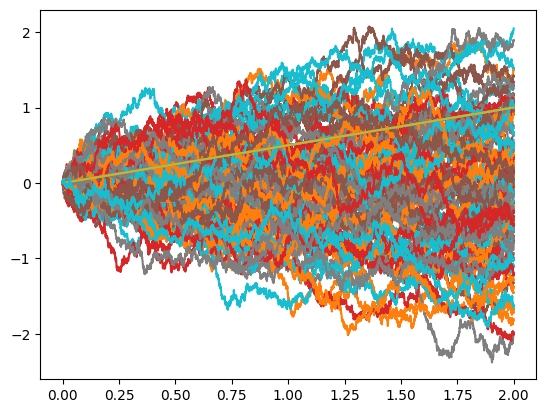

torch.Size([10000, 5000, 2])


In [ ]:
#Generate W and plot
plot_path(W_hat,2,np.arange(100))
print(W_hat.shape)

In [ ]:
sig=getsig(W_hat,depth)
for i in range(depth+1):
    print(sig[i].shape)
    print(l[i].shape)

torch.Size([10000, 1])
torch.Size([1])
torch.Size([10000, 2])
torch.Size([2])
torch.Size([10000, 2, 2])
torch.Size([2, 2])


/tmp/ipython-input-893177635.py:12: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  hyperrow=l[n][indices]
/tmp/ipython-input-893177635.py:15: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  Z[indices]+=hyperrow


tensor(427.5838)


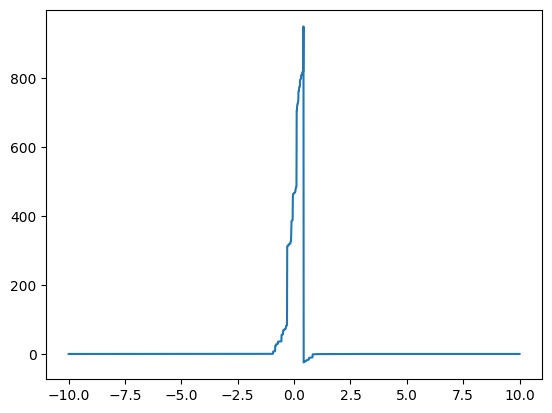

In [ ]:
x=torch.linspace(-10,10,2000)
plt.plot(x,p2(t,x,l,sig,W_hat,T))
print(Riemann_Integral(p2(t,x,l,sig,W_hat,T),x))
plt.show()

In [ ]:
# 2nd expamle: reproducing polynomial
batchsize = 100000
points = 200
d=1+5
T=1.0
t=1
depth=1
W_hat=generate_aug_brownian(batchsize,points,d,T,0)
sig=getsig(W_hat,depth)
for i in range(depth+1):
    print(sig[i].shape)
    print(l[i].shape)

torch.Size([100000, 1])
torch.Size([1])
torch.Size([100000, 6])
torch.Size([2])


In [ ]:
np.random.seed(0)
ell=np.random.normal(0,d-1,d-1).tolist()

In [ ]:
ell=[0]+ell

In [ ]:
ell=torch.tensor(ell)

In [ ]:
l=[torch.zeros(1),ell]


In [ ]:
l

[tensor([0.]), tensor([ 0.0000,  8.8203,  2.0008,  4.8937, 11.2045,  9.3378])]

In [ ]:
X_t=scalar_product(l,sig)

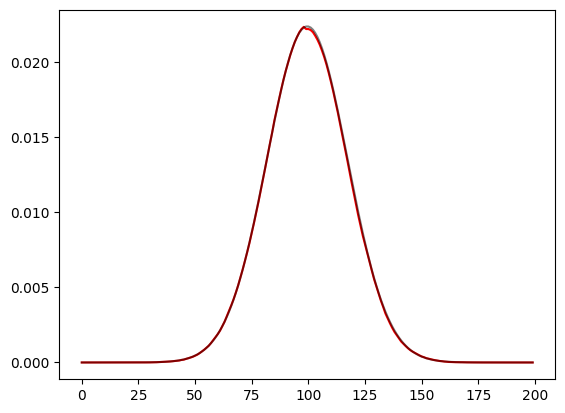

In [ ]:
x=torch.linspace(-100,100,200)
plt.plot(p2(t,x,l,sig,W_hat,T),color="red")
plt.plot(pol_P(t,x,l[1]),color="black",alpha=0.5)

### example 2: Comparaing both Formulas and their convergence

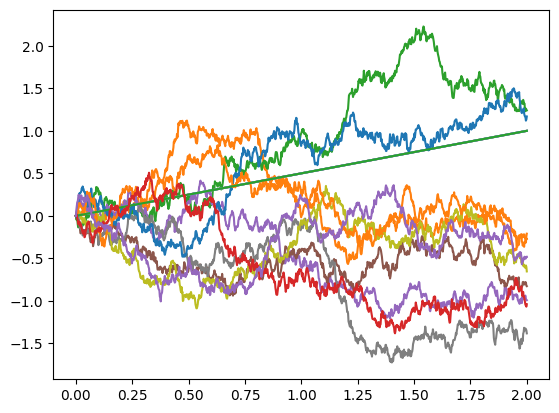

torch.Size([10000, 1000, 3])


In [ ]:
# Dimensions
batch_size=10000
points=1000
d=3
T=1
t=1
depth=4
l=[torch.randn(1)]
l+=[torch.randn(tuple([d]*k)) for k in range(1,depth + 1)]
W_hat=generate_aug_brownian(batch_size,points,d,T,0)
plot_path(W_hat,2,np.arange(5))
print(W_hat.shape)

In [ ]:
sig=getsig(W_hat,depth)
X_t=scalar_product(l,sig)

In [ ]:
X_t.shape

torch.Size([10000])

In [ ]:
x=np.linspace(-100,100,500)
results=[upgraded_p(x,X_t,H1(l,sig,W_hat,t,T,1)),upgraded_p(x,X_t,H2(l,sig,W_hat,t,T))]

/tmp/ipython-input-893177635.py:12: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  hyperrow=l[n][indices]
/tmp/ipython-input-893177635.py:15: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  Z[indices]+=hyperrow


In [ ]:
u=upgraded_p(x,X_t,H1(l,sig,W_hat,t,T,1))

/tmp/ipython-input-893177635.py:12: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  hyperrow=l[n][indices]
/tmp/ipython-input-893177635.py:15: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  Z[indices]+=hyperrow


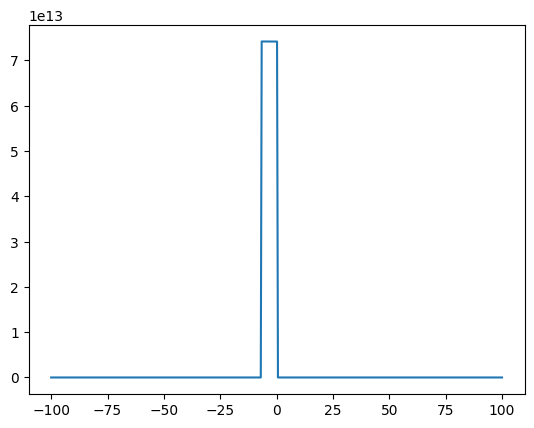

In [ ]:
plt.plot(x,u[1])

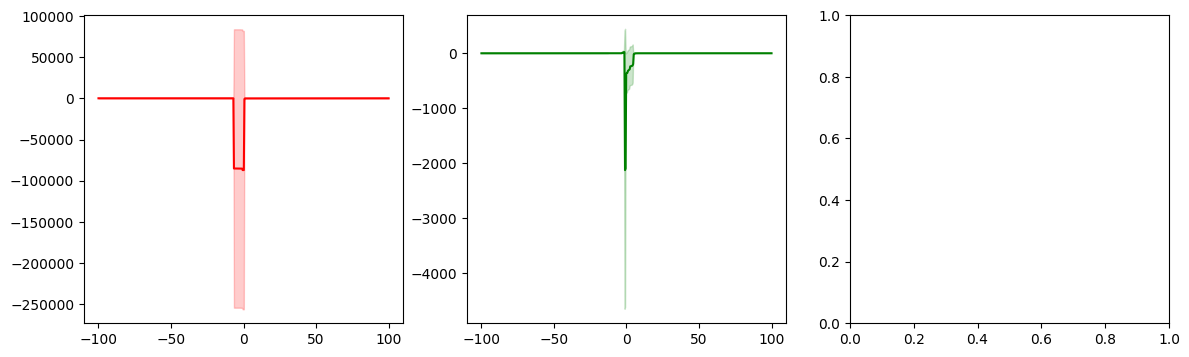

In [ ]:
q=1.96 # corresponds to 95% quantile of the standard-normal distribution
fig, ax = plt.subplots(1,3,figsize=(14,4))
for i in range(2):
  ax[i].plot(x,results[i][0],color=colors[i])
  ax[i].fill_between(x,results[i][0]-q*torch.sqrt(results[i][1])/np.sqrt(bs),results[i][0]+q*torch.sqrt(results[i][1])/np.sqrt(bs),color=colors[i],alpha=.2)

# 1-Dimensional Geometric Brownian

We consider $X_t=xe^{bt+\sigma W_t}$. We have computed $H(X_t,1)=X_t^{-1}(\frac{W_t}{t\sigma}+1)$, giving $$p_t(y)=\mathbb{E}[\mathbf{1}_{[y,\infty)}(X_t)H(X_t,1)]$$


In [ ]:
def geo_brow(paths,T,start_pt,b=0,sigma=1):
    # paths is the entire (non-augmented) brownian motion with shape: (batch_size, t_axis, dimension).
    # We assume here that dimension=1
    bs, pt, d =paths.shape
    t_axis = torch.linspace(0, T, pt).reshape((pt,1))
    return start_pt*torch.exp(b*t_axis+sigma*paths)


In [ ]:
def geo_H(X,W,t,T,sigma):
    bs, pt, d =X.shape
    return (1/X[:,time(t,T,pt),0])*(W[:,time(t,T,pt),0]/(t*sigma)+1)

In [ ]:
def geo_p(W,t,T,x,start_pt=1,b=0,sigma=1):
  X=geo_brow(W,T,start_pt,b,sigma)
  h_values=geo_H(X,W,t,T,sigma)
  bs, pt, d =X.shape
  return p(x,X[:,time(t,T,pt),0],h_values)

In [ ]:
def geo_P(t,x,start_pt=1,b=0,sigma=1):
    mask=x>0
    return mask*(1/(np.sqrt(2*np.pi*t*sigma**2))*np.exp(-(np.log(x/start_pt)-b*t)**2 / (2*sigma*t))/x)

In [ ]:
# EXAMPLE
batch_size=10000
points=200
d=1
t=1
T=1
start_point=1
sigma=1
b=3
W=generate_brownian(batch_size,points,d,T,1)
X=geo_brow(W,T,start_point,sigma=sigma,b=b)


In [ ]:
print(W.shape,X.shape,geo_H(X,W,t,T,sigma).shape)

torch.Size([10000, 200, 1]) torch.Size([10000, 200, 1]) torch.Size([10000])


/tmp/ipython-input-895862919.py:3: RuntimeWarning: divide by zero encountered in log
  return mask*(1/(np.sqrt(2*np.pi*t*sigma**2))*np.exp(-(np.log(x/start_pt)-b*t)**2 / (2*sigma*t))/x)
/tmp/ipython-input-895862919.py:3: RuntimeWarning: invalid value encountered in divide
  return mask*(1/(np.sqrt(2*np.pi*t*sigma**2))*np.exp(-(np.log(x/start_pt)-b*t)**2 / (2*sigma*t))/x)


[]

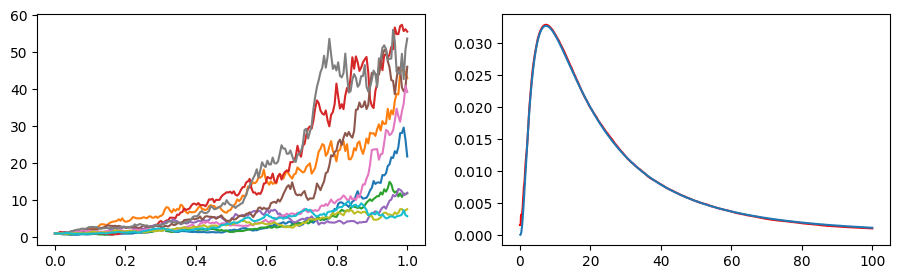

In [ ]:
x=np.linspace(0,100,1000)
fig,ax=plt.subplots(1,2,figsize=(11,3))
for i in range(10):
  ax[0].plot(np.linspace(0,1,200),X[i,:])
ax[1].plot(x,geo_p(W,t,T,x,start_pt=start_point,b=b,sigma=sigma),color='red')
ax[1].plot(x,geo_P(t,x=x,start_pt=1,b=b,sigma=1))
plt.plot()

# VolSto model

We assume $X_t=x\exp(-\int_0^t\frac{\sigma^2_s}{2}\mbox{d}s+\int_0^t\sigma_s\mbox{d}W_s)$, where $\sigma=\langle\ell,\widehat{\mathbb{W}}_t\rangle$ and assume that the brownian motion is 1-dimensional

We have to integrate sigma w.r.t $W_t$ and $t$ (depth 2 signature) so the entire path of sigma must be known. So we update previous functions (with v2_ in front) to make them more efficient at that.

In [ ]:
def get_sigma(l,W_hat):
    # W_hat a (augmented) brownian motion, l a tensor (R)^2

    sigs=signatory.Path(path=W_hat,depth=depth,scalar_term=True)
    batch_size,points,d=W_hat.shape
    #initialize X
    X=torch.zeros((batch_size,points,2))
    #at t=0, sig(W_hat)=1
    X[:,0,0]=l[0]
    signatures=torch
    sizes = [d**k for k in range(depth + 1)]
    l_prime=Psi(1,0,l,d)

    for i in range(2,points+1):
        sig=sigs.signature(end=i)
        lis=list(torch.split(sig, sizes, dim=1))

        X[:,i-1,0]=sum(torch.sum(h.flatten() * s, dim=1)
                     for h, s in zip(l, lis)
                    )
        X[:,i-1,1]=sum(torch.sum(h.flatten() * s, dim=1)
                     for h, s in zip(l_prime, lis)
                    )
    return X

In [ ]:
def Integral(W_hat,X):
  batch_size,points,d = W_hat.shape #d=2
  dW = (W_hat[:, 1:,:] - W_hat[:, :-1,:]) # (bs, pts-1, d)
  X_left=X[:,:-1] # (bs, pts-1)
  X_left_stack=torch.stack((X_left,X_left),dim=2) # (bs, pts-1, 2)
  return (X_left_stack*dW).sum(dim=1)

In [ ]:
#this function computes X at a given time t depending on an augmented brownian motion path W_hat and ell
def Volsto(x,t,T,l,W_hat):
    batch_size, points, d=W_hat.shape
    sigma=get_sigma(l,W_hat)[:,:,0]

    return x*torch.exp(-Integral(W_hat[:,:time(t,T,points),:],sigma[:,:time(t,T,points)]))[:,0]**2/2+Integral(W_hat[:,:time(t,T,points),:],sigma[:,:time(t,T,points)])[:,1]


In [ ]:
def weights(X_t,W_hat,sigma,t,T):
    bs,pts,d=W_hat.shape
    t_ax=time(t,T,pts)
    int1=Integral(W_hat[:,:t_ax,:],sigma[:,:t_ax,0]) # integral of sigma=<l,W>
    int2=Integral(W_hat[:,:t_ax,:],sigma[:,:t_ax,1]) # integral of <Psi(l),W>
    s=sigma[:,:t_ax,0]*sigma[:,:t_ax,1]
    int3=Integral(W_hat[:,:t_ax,:],s) # integral of sigma*<Psi(l),W>
    h=1/(X_t*int1[:,0])*(W_hat[:,t_ax,1]+int2[:,1]-int3[:,0]+(int2[:,0]/int1[:,0]))+1/X_t
    return h

In [ ]:
######TEST######
batch_size=10000
points=5000
d=2
depth=1
t=2
T=2
W_hat=generate_aug_brownian(batch_size,points,d,t,T)
l=[torch.tensor(0)]
l+=[torch.randn(tuple([d]*k)) for k in range(1,depth + 1)]

In [ ]:
sig=get_sigma(l,W_hat)

In [ ]:
sig.shape

torch.Size([10000, 5000, 2])

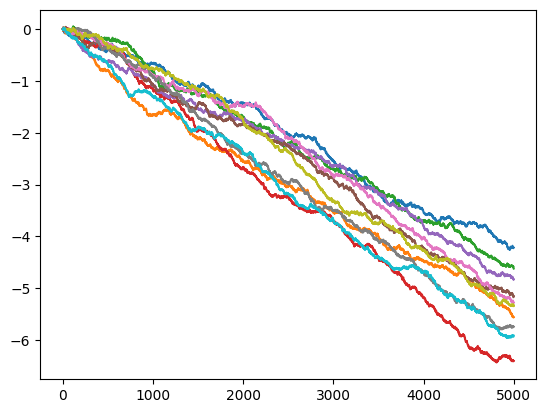

In [ ]:
for i in range(10):
  plt.plot(np.arange(points),sig[i,:,0])


In [ ]:
X_half=Volsto(1,1/2,T,l,W_hat)
X_1=Volsto(1,1,T,l,W_hat)
X_2=Volsto(1,2,T,l,W_hat)


In [ ]:
weight_half=torch.nan_to_num(weights(X_half,W_hat,sig,1/2,T),nan=0)
weight_1=torch.nan_to_num(weights(X_1,W_hat,sig,1,T),nan=0)
weight_2=torch.nan_to_num(weights(X_2,W_hat,sig,2,T),nan=0)


In [ ]:
X_2.shape

torch.Size([10000])

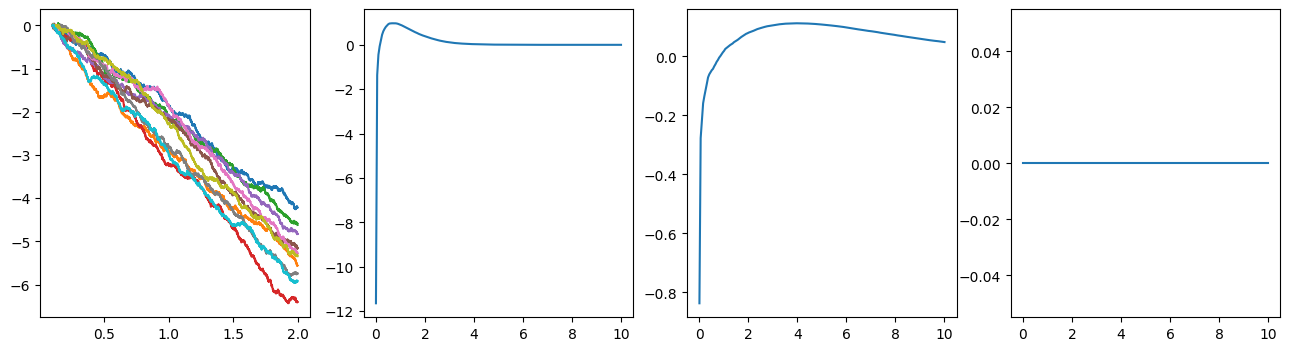

In [ ]:
fig,ax=plt.subplots(1,4,figsize=(16,4))

for i in range(10):
  ax[0].plot(np.linspace(0.1,T,points),sig[i,:,0])

x=torch.linspace(0,10,200)
u1=upgraded_p(x,X_half,weight_half)[0]
u2=upgraded_p(x,X_1,weight_1)[0]
u3=upgraded_p(x,X_2,weight_2)[0]
ax[1].plot(x,u1)
ax[2].plot(x,u2)
ax[3].plot(x,u3)
